# Plot NSE CDFs

Notebook 6/X

So far we have 1) calculted dynamic climate indices, 2) created climate nonstationarity configuration files, 3) created sister job scripts for SAC-SMA, sent off those models, 4) ensembled and analyzed the results, 5) performed more in-depth analyses between two models.

Finally, we can plot metric CDFs for ALL of our experiments.

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import Libraries

In [2]:
# standard modules
import os
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

##### Notebook Configuration

Here we can define which metric we would like to plot in the CDFs. I will use the Nash-Sutcliffe Efficiency (NSE) Coefficient, which is most commonly used to vizualize hydrological model performance, but any metrics calculated in notebook 3/X can be used.

In [3]:
#########################################################################################

#Define if plots are inline or interactive
interactive_plots = False

#########################################################################################

##### Paths

In [4]:
#########################################################################################

#Path to working directory (current directory)
working_dir = Path(os.getcwd())

#Path to notebook_env_saves directory (.../notebook_env_saves)
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

**You should not have to edit anything below this cell.**

The cell below orients the notebook based on the parameters specifed above.

In [5]:
#########################################################################################

#Get names of avaliable metric functions
metrics = ['nse']
#Set corresponding metric plot lims
axes = [(-1,1,0,1)]
#Create dictionary for metrics and axes
metric_axes_dict = {m:a for (m,a) in zip(metrics, axes)}

#########################################################################################

#Make plots interactive or inline according to value of interactive_plots variable
if interactive_plots:
    %matplotlib notebook
    %matplotlib notebook
else:
    %matplotlib inline
    
#########################################################################################

### Load Source Data

In [6]:
#Retreive list of cdfs files avaliable in env_saves_dir
cdfs_list = [x for x in os.listdir(env_saves_dir) if x.startswith('cdf')]

In [7]:
#Initiate dictionary to store all loaded cdfs files
cdfs = {}

#For every file in cdfs_list...
for cdf in cdfs_list:
    
    #Define path to the file
    path = env_saves_dir / cdf
    
    #Get name from file name
    name = cdf.split('cdfs_')[1].split('.')[0]
    
    #Open path...
    with open(path,'rb') as f:
        
        #...and load
        cdfs[name] = pkl.load(f)

### Plot CDFs

 ##### Extreme vs. Random Train/Test Splits

First we will to create a 2x2 grid of CDF plots for a defined metric for the possible model/forcing pairs. In this case, NeuralHydrology/SAC-SMA and Daymet/NLDAS. Note that I only plot static NeuralHydrology experiments for this figure.

No handles with labels found to put in legend.


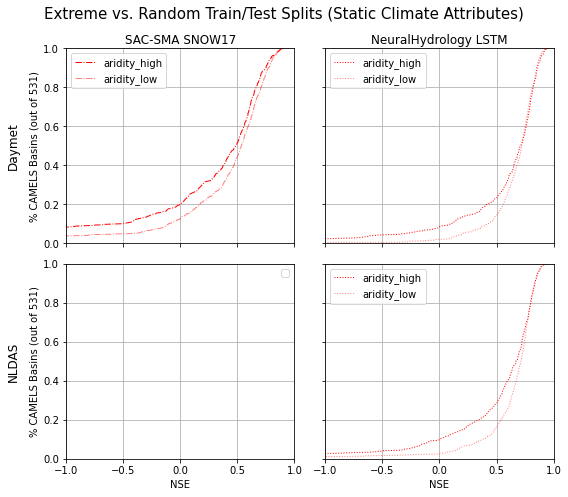

In [8]:
###Format Plot#####################################################

#Define columns and rows of plots
cols = ['SAC-SMA SNOW17','NeuralHydrology LSTM']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
#Row
ns = [0,0,1,1]
#Column
ms = [0,1,0,1]

###Define Variables################################################

#List of models (one for each plot)
models = ['sacsma','nh','sacsma','nh']
#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']

#List train/test split types
exp_types = ['extreme','random']
year = 'all'
inp = 'static'

###Plot Graph######################################################

#For every metric...
for metric in metrics:
    
    #Create a 2x2 grid of plots (one plot for each model/forcing pair)
    fig, axs = plt.subplots(2,2,figsize = (8,7))
    #Set subplot labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    #Define a pad distance between texts
    pad = 5

    #For every column...
    for ax, col in zip(axs[0], cols):

        #Create an annotation to signify model type
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #For every row...
    for ax, row in zip(axs[:,0], rows):

        #Create an annotation to signify forcing type
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center',rotation=90)

    #For a given position(n,m) where a model/forcing pair is to be plot...
    for n,m,model,forcing in zip(ns,ms,models,forcings):

        #For every train/test split type...
        for exp_type in exp_types:

            #Create name from scratch to ensure proper calling
            #Naming format changes depending on model type
            if model == 'nh':
                name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
            if model == 'sacsma':
                name = f'{model}_{exp_type}_{forcing}_{year}'
            
            #And if that name matches a key in the cdfs dictionary...
            if name in cdfs.keys():

                #Use that name to access a run's experiments
                experiments = cdfs[name].keys()

                #Set r to 0 (keeps count of how many random cdf lines we plot...
                #...so we don't have 500 "random"s on the legend)
                r = 0

                #For every experiment...
                for experiment in experiments:

                    #Retrieve x and y values from cdfs dictionary
                    x = cdfs[name][experiment][metric]['x']
                    y = cdfs[name][experiment][metric]['y']

                    #Default color, transparency, line width, and line type
                    c = 'r'
                    alpha = 1
                    lw = 1
                    l = ':'

                    #If we are plotting p_mean...
                    if 'p' in experiment:

                        #Ignore it for now
                        continue

                    #If it was a 'low' experiment...
                    if 'low' in experiment:

                        #Decrease the alpha to make it a lighter color
                        alpha = 0.5

                    #If sacsma model...
                    if 'sacsma' in name:

                        #Make the line dash-dot and line width 1
                        l = '-.'

                    #If random experiment...
                    if 'random' in name:

                        #Add 1 to r variable
                        r = r + 1
                        #Make line grey
                        c = 'grey'
                        #Decrease alpha
                        alpha = 0.6

                        #If sacsma model...
                        if 'sacsma' in name:

                            #Decrease line width
                            l = '-.'

                        #If are isn't 1, then set label to None
                        if r != 1:

                            axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                            continue

                        else:

                            #Plot x,y with the defined line type/color,width, alpha, and label 
                            axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'random')
                            continue

                    #Plot x,y with the defined line type/color,width, alpha, and label 
                    axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=experiment)

        #Show legend
        axs[n,m].legend()

        #Set axes limits (currently hardcoded for NSE)
        axs[n,m].set_xlim(left=-1, right=1)
        axs[n,m].set_ylim(bottom=0, top=1)
        
        #Plot grid
        axs[n,m].grid()

    #Only show labels for outter plots
    for ax in axs.flat:
        ax.label_outer()  

    #Create main figure title
    fig.suptitle(f'Extreme vs. Random Train/Test Splits (Static Climate Attributes)', fontsize=15,ha='center')

    #Show plot
    plt.tight_layout()

In [9]:
#If plot interactive, must explicitly close
plt.close()

##### All Years vs. Only NWM Years

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm.

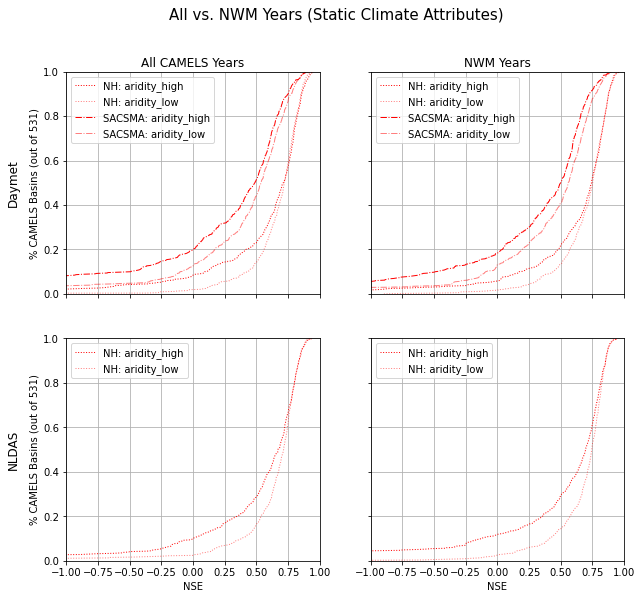

In [10]:
###Format Plot#####################################################

#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
#Row
ns = [0,0,1,1]
#Column
ms = [0,1,0,1]

###Define Variables################################################

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']
#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of models
models = ['nh','sacsma']
#List of experiment types
exp_types = ['extreme','random']
inp = 'static'

###Plot Graph######################################################

for metric in metrics:

    #Create a 2x2 grid of plots (one plot for each forcing/year pair)
    fig, axs = plt.subplots(2,2,figsize = (10,9))
    #Set subplot labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    #Define a pad distance between texts
    pad = 5

    #For every column...
    for ax, col in zip(axs[0], cols):

        #Create an annotation to signify years
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #For every row...
    for ax, row in zip(axs[:,0], rows):

        #Create an annotation to signify forcing
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    #For a given position (n,m) where a forcing/year pair is to be plot...
    for n,m,forcing,year in zip(ns,ms,forcings,years):
        #For each model...
        for model in models:
            #And for each experiment type...
            for exp_type in exp_types:
                
                #Create name from scratch to ensure proper calling
                #Naming format changes depending on model type
                if model == 'nh':
                    name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
                if model == 'sacsma':
                    name = f'{model}_{exp_type}_{forcing}_{year}'
                    
                #And if that name matches a key in the cdfs dictionary...
                if name in cdfs.keys():

                    #Use that name to access a run's experiments
                    experiments = cdfs[name].keys()

                    #Set r to 0 (keeps count of how many random cdf lines we plot...
                    #...so we don't have 500 "random"s on the legend)
                    r = 0

                    #For every experiment...
                    for experiment in experiments:

                        #Retrieve x and y values from cdfs dictionary
                        x = cdfs[name][experiment][metric]['x']
                        y = cdfs[name][experiment][metric]['y']

                        #Default color, transparency, line width, and line type
                        c = 'r'
                        alpha = 1
                        lw = 1
                        l = ':'

                        #If we are plotting p_mean...
                        if 'p' in experiment:

                            continue

                        #If it was a 'low' experiment...
                        if 'low' in experiment:

                            #Decrease the alpha to make it a lighter color
                            alpha = 0.5

                        #If sacsma model...
                        if 'sacsma' in name:

                            #Make the line dash-dot and line width 1
                            l = '-.'

                        #If random experiment...
                        if 'random' in name:

                            #Add 1 to r variable, make line grey, decrease alpha
                            r = r + 1
                            c = 'grey'
                            alpha = 0.6

                            #If sacsma model...
                            if 'sacsma' in name:

                                #Decrease line width
                                l = '-.'

                            #If are isn't 1, then set label to None
                            if r != 1:

                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                                continue

                            else:

                                #Plot x,y with the defined line type/color,width, alpha, and label 
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}_random')
                                continue
                                
                        #Plot x,y with the defined line type/color,width, alpha, and label 
                        axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: {experiment}')

        #Show legend
        axs[n,m].legend()

        #Set axes limits
        axs[n,m].set_xlim(left=-1, right=1)
        axs[n,m].set_ylim(bottom=0, top=1)
        
        #Plot grid
        axs[n,m].grid()

    #Only show labels for outside plots
    for ax in axs.flat:
        ax.label_outer()   

    #Create main figure title
    fig.suptitle(f'All vs. NWM Years (Static Climate Attributes)', fontsize=15)

    #Show plot
    plt.show()

In [11]:
#If plot interactive, must explicitly close
plt.close()

##### Static Attributes vs. Dynamic Climate Index Inputs

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm. This time, however, instead of plotting SAC-SMA we are only plotting NeuralHydrology. Also, instead of only plotting static experiments, we plot both static and dynamic.

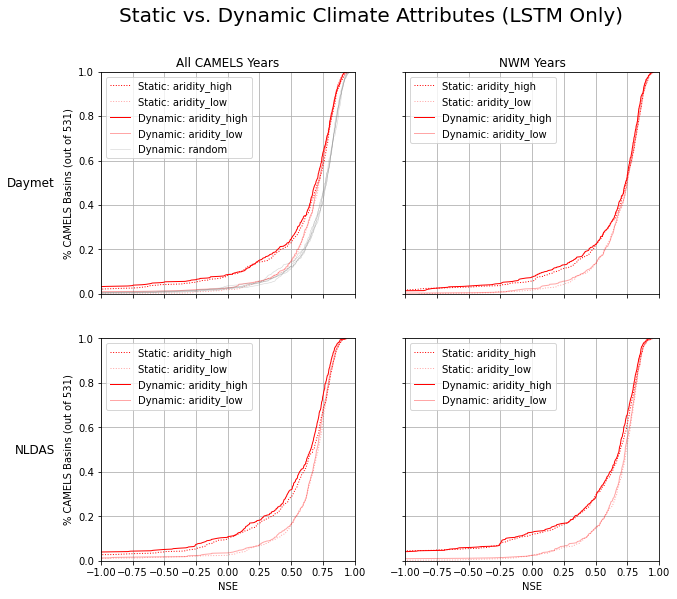

In [12]:
###Format Plot#####################################################

#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
ns = [0,0,1,1]
ms = [0,1,0,1]

###Define Variables################################################

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']
#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of experiment types
exp_types = ['extreme','random']
#List of inputs
inputs = ['static','dynamic']

#Only plot neuralhydrology models
model = 'nh'

###Plot Graph######################################################

for metric in metrics:

    #Create a 2x2 grid of plots (one plot for each forcing/year pair)
    fig, axs = plt.subplots(2,2,figsize = (10,9))

    #Set subplot labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    #Define a pad distance between texts
    pad = 5

    #For every column...
    for ax, col in zip(axs[0], cols):

        #Create an annotation to signify years
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #For every row...
    for ax, row in zip(axs[:,0], rows):

        #Create an annotation to signify forcing
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    #For a given position (n,m) where a model/forcing pair is to be plot...
    for n,m,forcing,year in zip(ns,ms,forcings,years):

        #For each input type...
        for inp in inputs:

            #For each experiment type...
            for exp_type in exp_types:

                #Define a name with the current iterators
                name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'

                #And if that name is in the cdfs dictionary...
                if name in cdfs.keys():

                    #Go into that dictionary and retrieve experiment names
                    experiments = cdfs[name].keys()

                    #Set r to 0 (keeps count of how many random cdf lines we plot...
                    #...so we don't have 500 "random"s on the legend)
                    r = 0

                    #For every experiment...
                    for experiment in experiments:

                        #Retrieve x and y values from cdfs dictionary
                        x = cdfs[name][experiment]['nse']['x']
                        y = cdfs[name][experiment]['nse']['y']

                        #Default color, transparency, line width, and line type
                        c = 'r'
                        alpha = 1
                        lw = 1
                        l = ':'

                        #If dynamic model...
                        if 'dynamic' in name:

                            #Line type is solid
                            l = '-'

                        #If p_mean...
                        if 'p' in experiment:

                            continue

                        #If 'low' experiment...
                        if 'low' in experiment:

                            #Decrease alpha to make lighter color
                            alpha = 0.35

                        #If a random experiment...
                        if 'random' in name:

                            #Add count to r variable and make line grey
                            r = r + 1
                            c = 'grey'
                            lw = 1
                            alpha = 0.5

                            #If dynamic, make line solid
                            if 'dynamic' in name:
                                lw = 0.5
                                alpha = 0.4

                            #If are isn't 1, then set label to None
                            if r != 1:

                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                                continue

                            else:

                                #Plot x,y with the defined line type/color,width, alpha, and label 
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{inp.capitalize()}: random')
                                continue

                        #Plot x,y with the defined line type/color,width, alpha, and label 
                        axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{inp.capitalize()}: {experiment}')

        axs[n,m].legend()

        #Set axes limits
        axs[n,m].set_xlim(left=-1, right=1)
        axs[n,m].set_ylim(bottom=0, top=1)
        
        axs[n,m].grid()


    #Only show labels for outside plots
    for ax in axs.flat:
        ax.label_outer()   

    #Create main figure title
    fig.suptitle(f'Static vs. Dynamic Climate Attributes (LSTM Only)', fontsize=20)

    #Show plot
    plt.show()

In [13]:
#If plot interactive, must explicitly close
plt.close()